# Logistic Regression and Classification Error Metrics
![LogRegr.png](Assets/LogRegr.png)


# Learning Objectives

- Describe Logistic regression and how it differs from linear regression
- Identify metrics for classification errors and scenarios in which they can be used
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware


# scikit-learn* 

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written. 

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed. 

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems. 

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code PRIOR to importing sklearn: 

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv 

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
from __future__ import print_function
import os
data_path = ['../resources']

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = 'resources/Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

3054    2
4515    5
3999    2
7057    0
2148    3
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

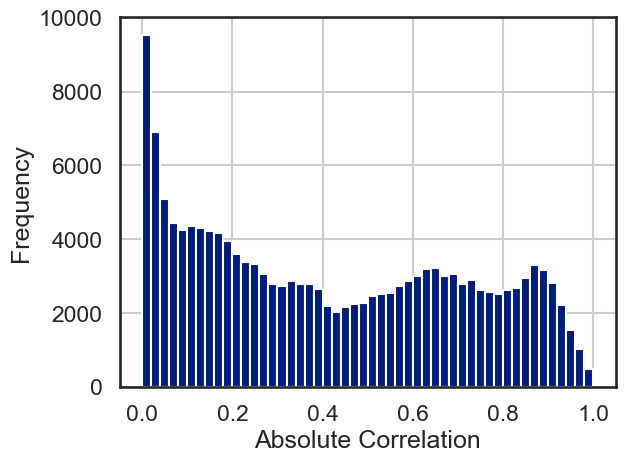

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [14]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(C=.001, max_iter=295).fit(X_train, y_train)

In [18]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [19]:
# Fitting logistic regression models with different solvers
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
for solver in solvers:
    lr_solver = LogisticRegression(C=0.001, max_iter=1000, solver=solver, multi_class='auto').fit(X_train, y_train)
    train_accuracy = lr_solver.score(X_train, y_train)
    test_accuracy = lr_solver.score(X_test, y_test)
    print(f'Solver: {solver}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

Solver: newton-cg, Training Accuracy: 0.9082, Test Accuracy: 0.9104
Solver: lbfgs, Training Accuracy: 0.9082, Test Accuracy: 0.9104
Solver: sag, Training Accuracy: 0.9082, Test Accuracy: 0.9104
Solver: saga, Training Accuracy: 0.9083, Test Accuracy: 0.9104


In [22]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=1, cv=4, penalty='l2').fit(X_train, y_train)

C:\Users\soura\venv\Lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:629: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [23]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
301 -0.014835  0.004177  0.033146 -0.020272 -0.047840  0.045623  0.296113   
199  0.004394  0.032544 -0.045356  0.041639 -0.016818 -0.016402 -1.069473   
454  0.020220 -0.072399  0.038295 -0.005640  0.018862  0.000662  0.676735   
141 -0.013445 -0.014931 -0.024478 -0.012404 -0.006924  0.072181 -0.089266   
160 -0.001204  0.002217 -0.001838 -0.000360  0.007100 -0.005916  0.000000   
375 -0.003097 -0.013733 -0.017276  0.025034 -0.002420  0.011492  0.100571   
4   -0.021306 -0.024444 -0.037169  0.030203  0.001433  0.051283  0.000000   
279 -0.000716  0.001872 -0.006684  0.004218  0.003699 -0.002390  0.000000   
137 -0.004543 -0.005612 -0.007561  0.013690 -0.009189  0.013216  0.000000   
286 -0.010232 -0.013559 -0.017879  0.013852  0.044686 -0.016867 -0.015415   

                                                              l2            \
             1         2         3         4         5         0         1   
301   1.210682  0.862377  0.000000  0.206914 -0.256109 -0.006308  0.003886   
199   0.082035  0.214853  1.004216  1.872278 -3.358168  0.001702  0.003839   
454  -3.273465  0.816449  0.000000  0.019279  0.131214  0.004845 -0.012334   
141   0.000000  0.000000 -4.067799  0.439093  2.904666 -0.007711 -0.008063   
160  13.837539  0.000000  0.000000  0.000000  2.391676 -0.000380  0.000324   
375  -0.000129  0.000000  0.010878  0.000000 -1.013810 -0.003484 -0.005697   
4     0.240946 -1.299145  0.000000 -0.896241 -0.451582 -0.013262 -0.013672   
279   4.488814  0.000000  0.000000  0.000000  0.803576 -0.001567 -0.001241   
137   0.000000  0.000000  0.000000 -0.086157  0.286823 -0.003056 -0.003195   
286   0.243435  0.000000  0.000000  0.832721 -0.618364 -0.006414 -0.007062   

                                             
            2         3         4         5  
301  0.007920 -0.006441 -0.012571  0.013515  
199 -0.009429  0.006813 -0.003714  0.000789  
454  0.003481 -0.002593  0.002371  0.004231  
141 -0.009856  0.002638  0.004062  0.018930  
160 -0.000217 -0.000154  0.001805 -0.001378  
375 -0.005983  0.006445  0.002997  0.005723  
4   -0.015948  0.014155  0.010954  0.017796  
279 -0.002585  0.001848  0.002317  0.001229  
137 -0.003784  0.003672  0.000730  0.005634  
286 -0.008002  0.007711  0.014193 -0.000426

Prepare six separate plots for each of the multi-class coefficients.

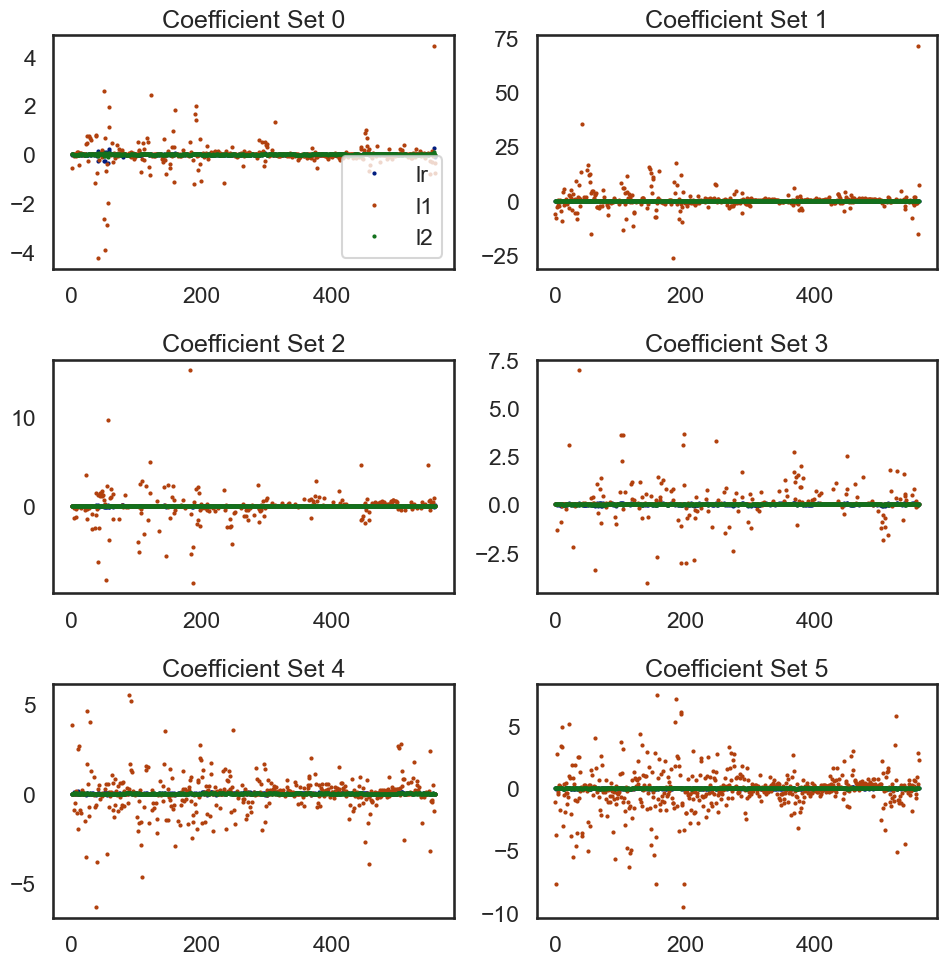

In [24]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [25]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


C:\Users\soura\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [26]:
y_prob.head()

,lr,l1,l2
0,0.733037,0.998880,0.344193
1,0.510313,0.999520,0.313596
2,0.561760,0.999342,0.305891
3,0.537524,0.999198,0.333243
4,0.822264,1.000000,0.486693


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [27]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [28]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.911089,0.982529,0.866900
recall,0.910356,0.982524,0.852427
fscore,0.909827,0.982524,0.845593
accuracy,0.910356,0.982524,0.852427
auc,0.945884,0.989366,0.910622


## Question 8

Display or plot the confusion matrix for each model.

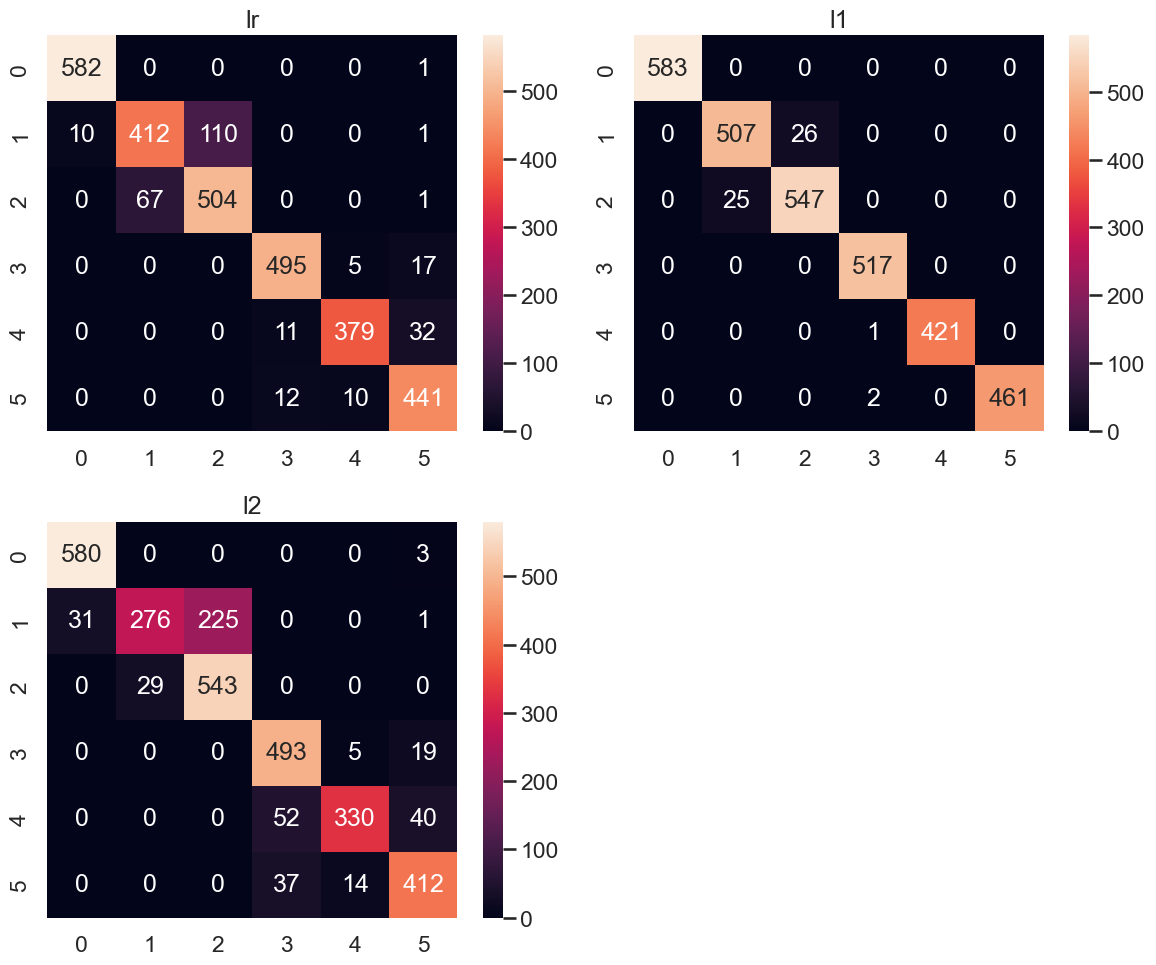

In [29]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))


data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

C:\Users\soura\venv\Lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:629: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\soura\venv\Lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:629: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Metrics for Standard LR:
Accuracy: 0.8686084142394822
Precision: 0.8704851393472576
Recall: 0.8686084142394822
F-score: 0.8673008994304197
AUC: 0.9208502501399373
Confusion Matrix: [[584   2   9   0   0   3]
 [ 26 389 118   2   0   8]
 [  3  89 458   1   0   6]
 [  0   1   4 511   7  23]
 [  0   0   0  46 336  40]
 [  0   2   2   6   8 406]]

Metrics for L1 Regularized LR:
Accuracy: 0.9598705501618123
Precision: 0.9599010712811213
Recall: 0.9598705501618123
F-score: 0.9598093968212161
AUC: 0.9757046088879485
Confusion Matrix: [[598   0   0   0   0   0]
 [  0 489  50   3   0   1]
 [  0  42 514   0   0   1]
 [  0   0   0 542   2   2]
 [  0   0   0  10 409   3]
 [  0   0   0   7   3 414]]

Metrics for L2 Regularized LR:
Accuracy: 0.9566343042071197
Precision: 0.9568729572453111
Recall: 0.9566343042071197
F-score: 0.9566280532133931
AUC: 0.9737900528398923
Confusion Matrix: [[598   0   0   0   0   0]
 [  1 484  56   1   0   1]
 [  0  38 519   0   0   0]
 [  0   1   1 534   3   7]
 [  0   0

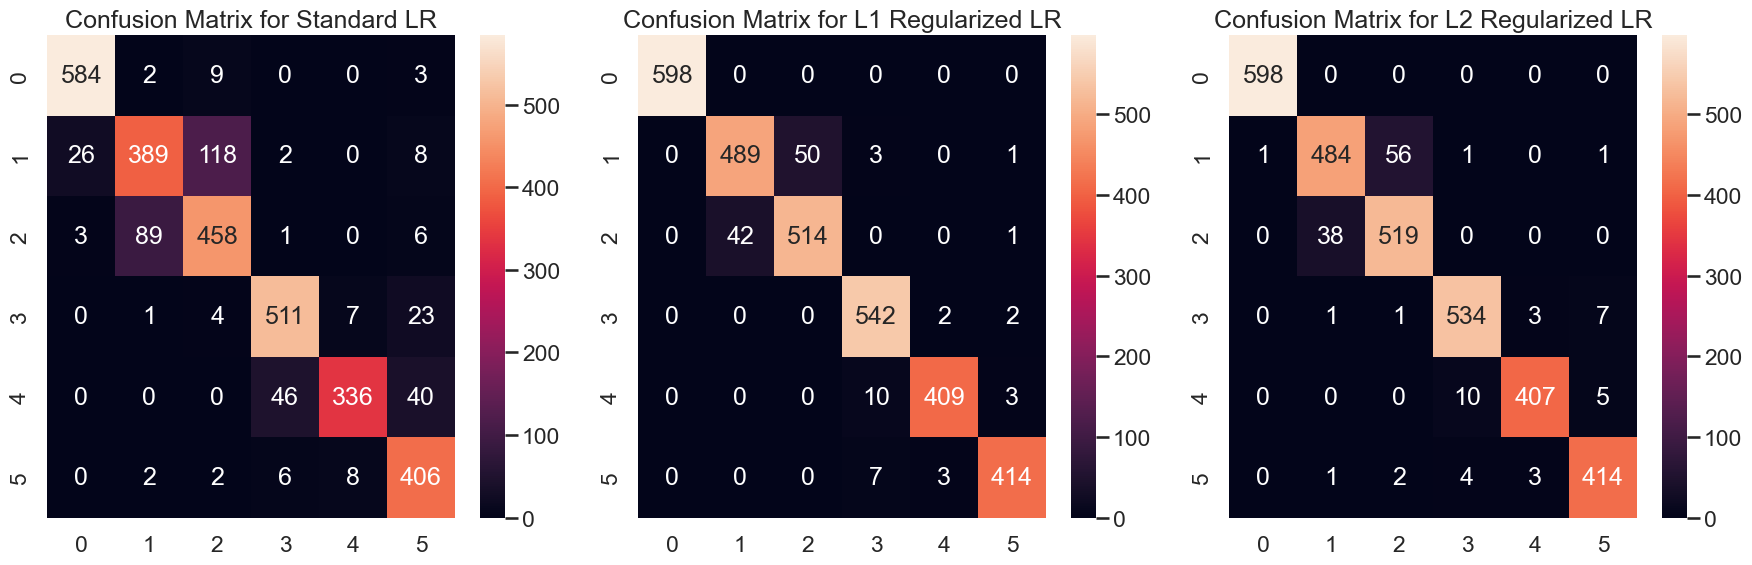

In [31]:
# Importing necessary libraries
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying highly correlated columns and dropping them
corr_threshold = 0.7
highly_correlated_columns = set()
corr_matrix = data2.corr().abs()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] >= corr_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated_columns.add(colname)

# Dropping highly correlated columns
data_new_filtered = data2.drop(columns=highly_correlated_columns)

# Splitting the data into train and test sets
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(data_new_filtered, data_y, test_size=0.3, random_state=42)

# Model building with the new training data
# Standard logistic regression
lr_new = LogisticRegression(C=0.001, max_iter=1000, solver='lbfgs', multi_class='auto').fit(X_new_train, y_new_train)

# L1 regularized logistic regression
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', multi_class='auto').fit(X_new_train, y_new_train)

# L2 regularized logistic regression
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', multi_class='auto').fit(X_new_train, y_new_train)

# Evaluating the models
models = {'Standard LR': lr_new, 'L1 Regularized LR': lr_l1_new, 'L2 Regularized LR': lr_l2_new}
metrics_new = {}

for model_name, model in models.items():
    y_pred_new = model.predict(X_new_test)
    y_prob_new = model.predict_proba(X_new_test)
    accuracy = accuracy_score(y_new_test, y_pred_new)
    precision, recall, fscore, _ = score(y_new_test, y_pred_new, average='weighted')
    auc = roc_auc_score(label_binarize(y_new_test, classes=[0, 1, 2, 3, 4, 5]),
                        label_binarize(y_pred_new, classes=[0, 1, 2, 3, 4, 5]), average='weighted')
    confusion_mat = confusion_matrix(y_new_test, y_pred_new)
    metrics_new[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F-score': fscore,
                                'AUC': auc, 'Confusion Matrix': confusion_mat}

# Displaying the metrics
for model_name, metrics in metrics_new.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()

# Plotting confusion matrices
fig, axList = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 6)

for idx, (model_name, model) in enumerate(models.items()):
    ax = axList[idx]
    sns.heatmap(confusion_matrix(y_new_test, model.predict(X_new_test)), ax=ax, annot=True, fmt='d')
    ax.set_title(f'Confusion Matrix for {model_name}')

plt.tight_layout()
plt.show()

In [32]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [34]:
import pandas as pd

# Combine all the coefficients into a dataframe
coefficients = pd.DataFrame({
    'Feature': X_new_train.columns,
    'Standard_LR_Coefficient': lr_new.coef_[0],  # Accessing coefficients for the first class
    'L1_Regularized_LR_Coefficient': lr_l1_new.coef_[0],  # Accessing coefficients for the first class
    'L2_Regularized_LR_Coefficient': lr_l2_new.coef_[0]  # Accessing coefficients for the first class
})

coefficients.head()

,Feature,Standard_LR_Coefficient,L1_Regularized_LR_Coefficient,L2_Regularized_LR_Coefficient
0,tBodyAcc-mean()-X,-0.006953,-1.761908,-1.619931
1,tBodyAcc-mean()-Y,0.000479,0.000000,-16.513038
2,tBodyAcc-mean()-Z,0.002521,2.885292,11.591016
3,tBodyAcc-std()-X,-0.185881,-0.680137,-13.284002
4,"tBodyAcc-arCoeff()-Y,1",0.109820,-0.331456,8.114679


Prepare six separate plots for each of the multi-class coefficients.

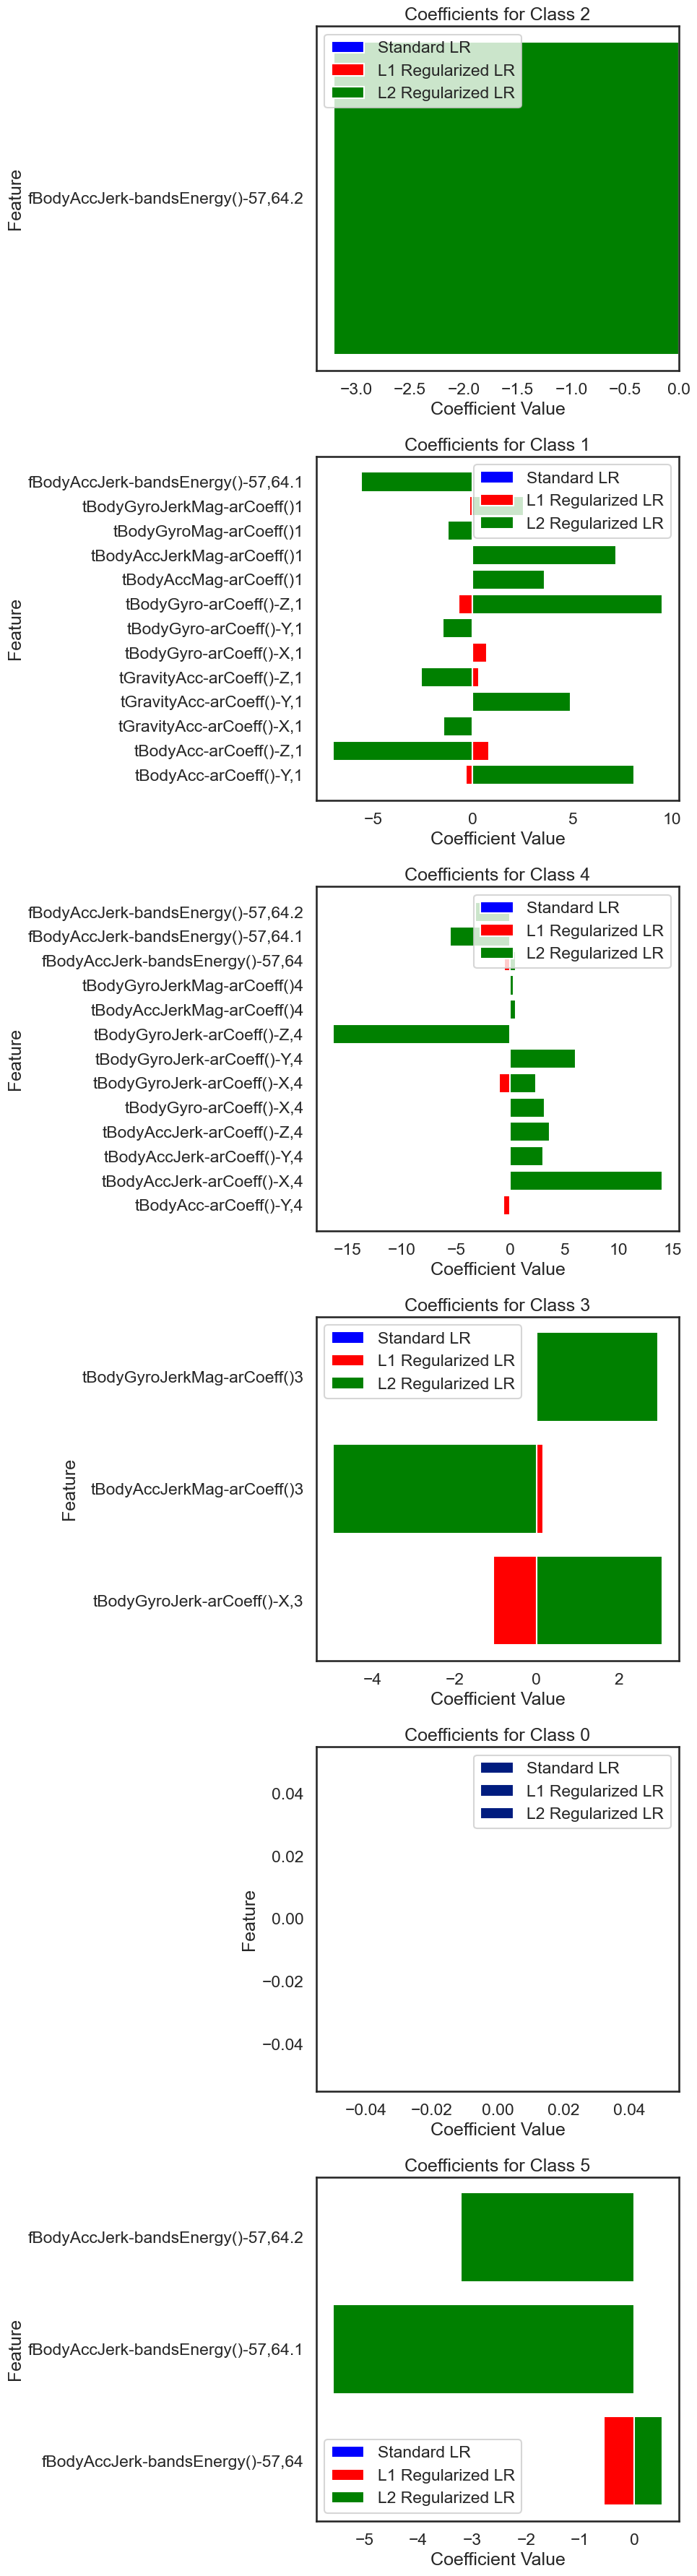

In [37]:
import matplotlib.pyplot as plt

# Get unique class labels
class_labels = y_new_train.unique()

# Prepare subplots
fig, axes = plt.subplots(nrows=len(class_labels), ncols=1, figsize=(10, 6 * len(class_labels)))

# Iterate over each class

# Iterate over each class
for i, label in enumerate(class_labels):
    # Filter coefficients for the current class
    class_coefficients = coefficients[coefficients['Feature'].str.contains(str(label))]
    
    # Plot coefficients for each model
    ax = axes[i]
    ax.barh(y=class_coefficients['Feature'], width=class_coefficients['Standard_LR_Coefficient'], color='b', label='Standard LR')
    ax.barh(y=class_coefficients['Feature'], width=class_coefficients['L1_Regularized_LR_Coefficient'], color='r', label='L1 Regularized LR')
    ax.barh(y=class_coefficients['Feature'], width=class_coefficients['L2_Regularized_LR_Coefficient'], color='g', label='L2 Regularized LR')
    
    # Set title and labels
    ax.set_title(f'Coefficients for Class {label}')
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Feature')
    ax.legend()

plt.tight_layout()
plt.show()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [38]:
# Predictions for each model
y_pred = {}
y_prob = {}

# Standard logistic regression
y_pred['Standard_LR'] = lr_new.predict(X_new_test)
y_prob['Standard_LR'] = lr_new.predict_proba(X_new_test)

# L1 regularized logistic regression
y_pred['L1_Regularized_LR'] = lr_l1_new.predict(X_new_test)
y_prob['L1_Regularized_LR'] = lr_l1_new.predict_proba(X_new_test)

# L2 regularized logistic regression
y_pred['L2_Regularized_LR'] = lr_l2_new.predict(X_new_test)
y_prob['L2_Regularized_LR'] = lr_l2_new.predict_proba(X_new_test)


C:\Users\soura\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [39]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score

# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = score(y_true, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, fscore, confusion_mat

# Calculate metrics for each model
metrics = {}
for model_name in y_pred.keys():
    accuracy, precision, recall, fscore, confusion_mat = calculate_metrics(y_new_test, y_pred[model_name])
    metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F-score': fscore,
                           'Confusion Matrix': confusion_mat}

# Combine multi-class metrics into a single value for each model
for model_name, metric_dict in metrics.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metric_dict.items():
        print(f"{metric_name}: {value}")
    print()

Metrics for Standard_LR:
Accuracy: 0.8686084142394822
Precision: 0.8704851393472576
Recall: 0.8686084142394822
F-score: 0.8673008994304197
Confusion Matrix: [[584   2   9   0   0   3]
 [ 26 389 118   2   0   8]
 [  3  89 458   1   0   6]
 [  0   1   4 511   7  23]
 [  0   0   0  46 336  40]
 [  0   2   2   6   8 406]]

Metrics for L1_Regularized_LR:
Accuracy: 0.9598705501618123
Precision: 0.9599010712811213
Recall: 0.9598705501618123
F-score: 0.9598093968212161
Confusion Matrix: [[598   0   0   0   0   0]
 [  0 489  50   3   0   1]
 [  0  42 514   0   0   1]
 [  0   0   0 542   2   2]
 [  0   0   0  10 409   3]
 [  0   0   0   7   3 414]]

Metrics for L2_Regularized_LR:
Accuracy: 0.9566343042071197
Precision: 0.9568729572453111
Recall: 0.9566343042071197
F-score: 0.9566280532133931
Confusion Matrix: [[598   0   0   0   0   0]
 [  1 484  56   1   0   1]
 [  0  38 519   0   0   0]
 [  0   1   1 534   3   7]
 [  0   0   0  10 407   5]
 [  0   1   2   4   3 414]]


## Question 13

Display or plot the confusion matrix for each model.

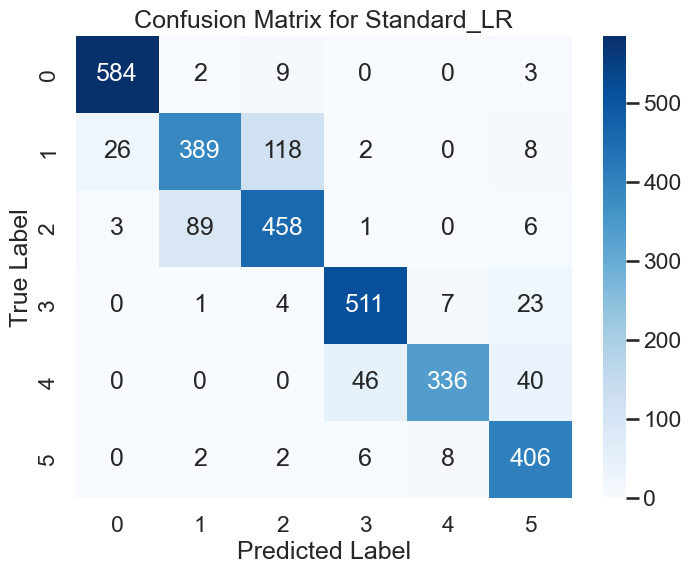

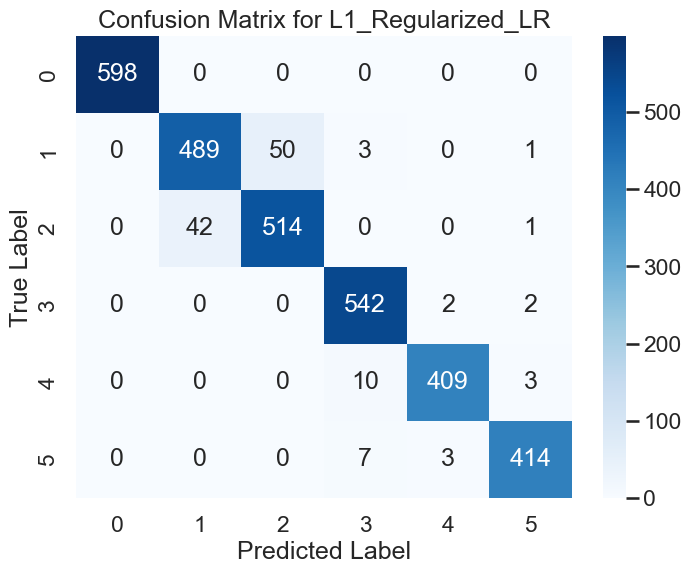

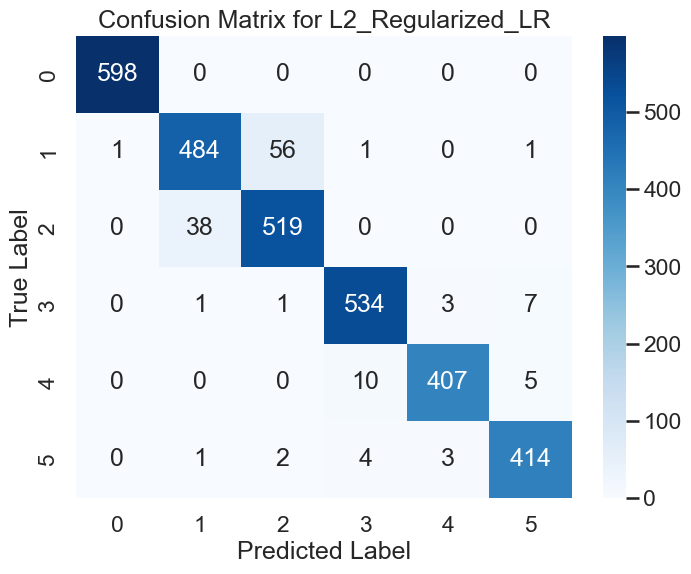

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrices
for model_name, confusion_mat in metrics.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()